In [2]:
import model
import pickle
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
prep_data = model.data_and_network_prep()

In [4]:
data_for_fit_i = model.create_data_for_fit_influenza()
data_for_fit_v = model.create_data_for_fit(prep_data)

In [5]:
# Get list of files
# path = 'L:/Dor/Data/coupled_model/model_results'
# path = 'L:/Dor/Data/coupled_model/model_results_correction'
path = 'L:/Dor/Data/coupled_model/model_results_updated/1'

file_names = os.listdir(path)

# Merge lists
model_results_all = []
for file_name in file_names:
    with open(f'{path}/{file_name}', 'rb') as pickle_in:
        cur_res = pickle.load(pickle_in)
    model_results_all.extend(cur_res)

In [6]:
model_results_list = [res['model_results'] for res in model_results_all]

In [7]:
likelihood_lists = {season: [] for season in model.seasons}
for res in model_results_all:
    for season, likelihood in res['likelihood_by_season'].items():
        likelihood_lists[season].append(likelihood)

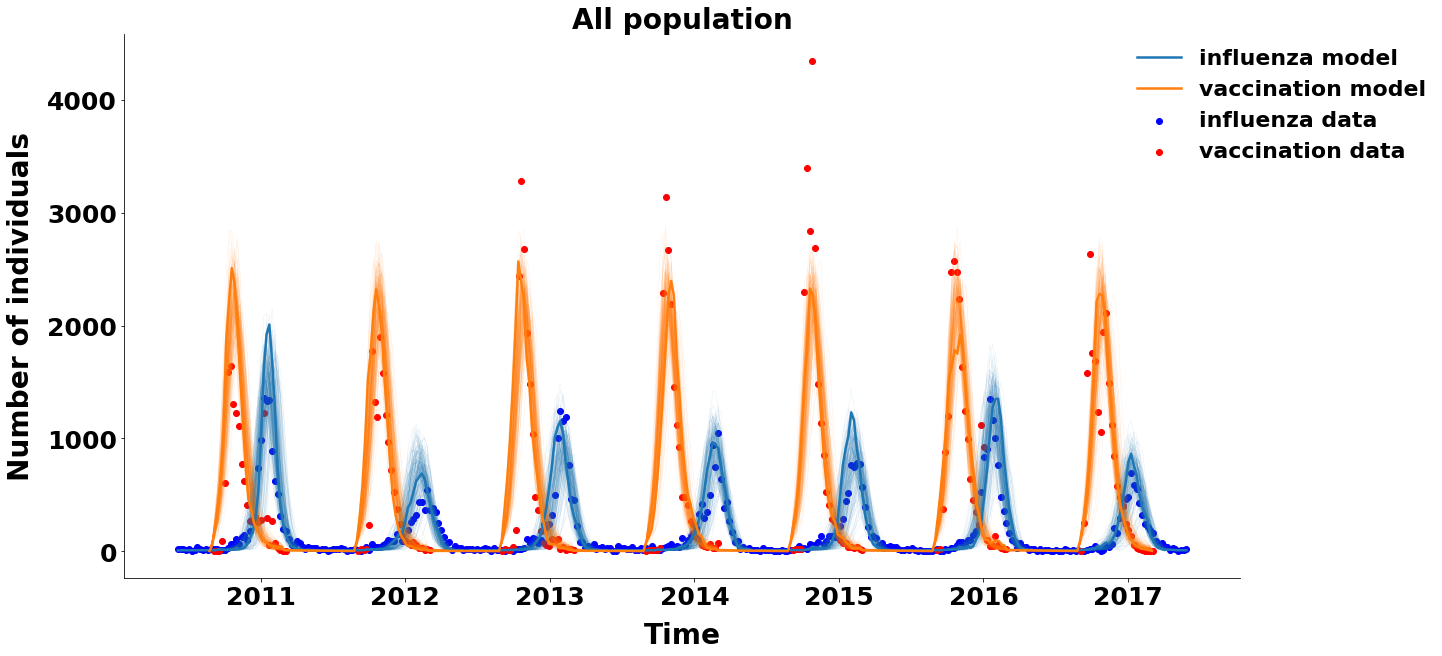

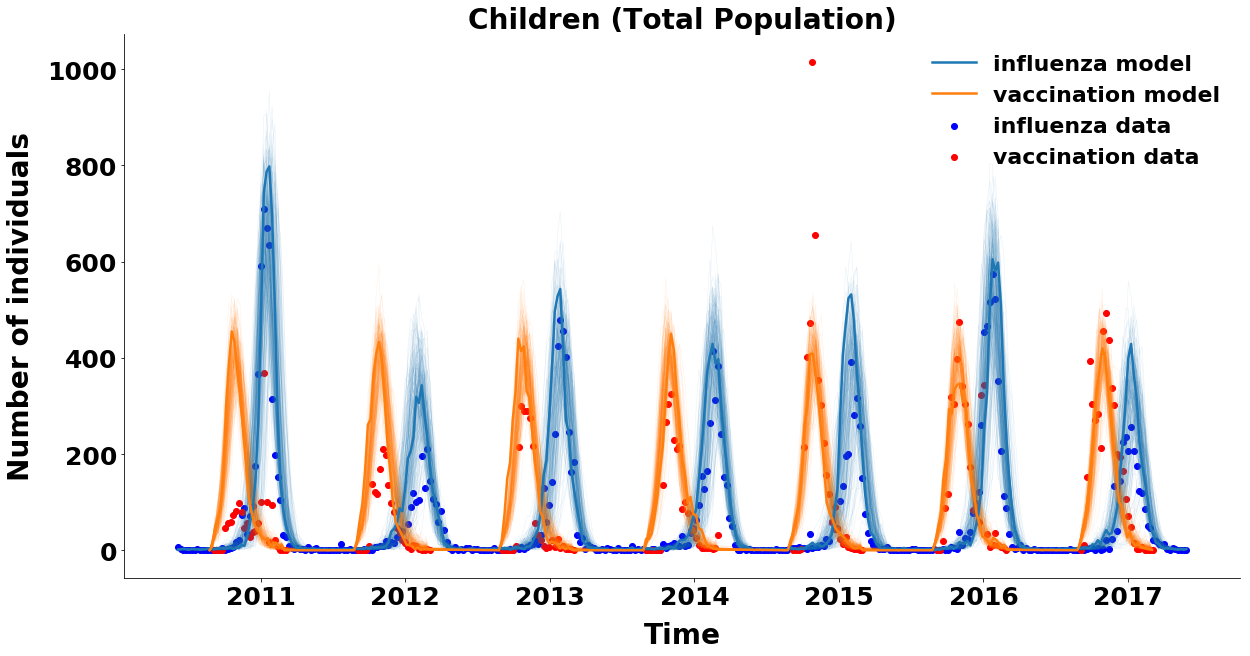

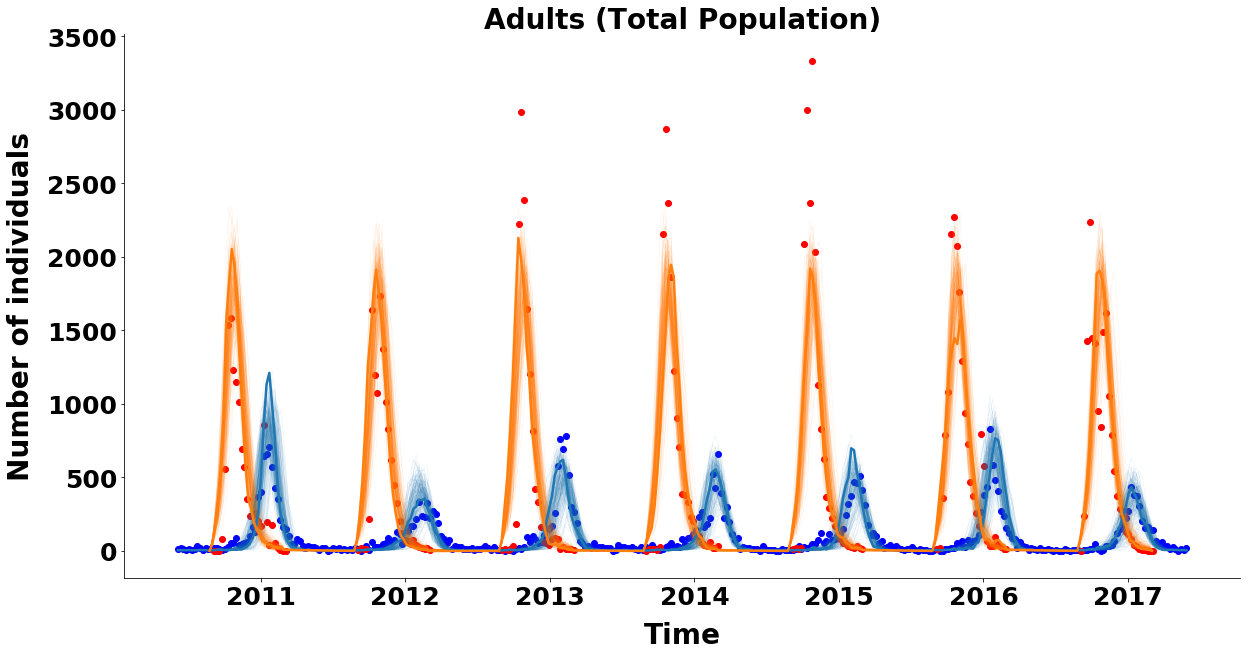

In [13]:
plot_aggregated_fit_coupled_with_cloud(model_results_list, likelihood_lists, data_for_fit_i, data_for_fit_v, prep_data)
plot_aggregated_fit_coupled_with_cloud(model_results_list, likelihood_lists, data_for_fit_i, data_for_fit_v, prep_data, age=0)
plot_aggregated_fit_coupled_with_cloud(model_results_list, likelihood_lists, data_for_fit_i, data_for_fit_v, prep_data, age=1, legend=False)

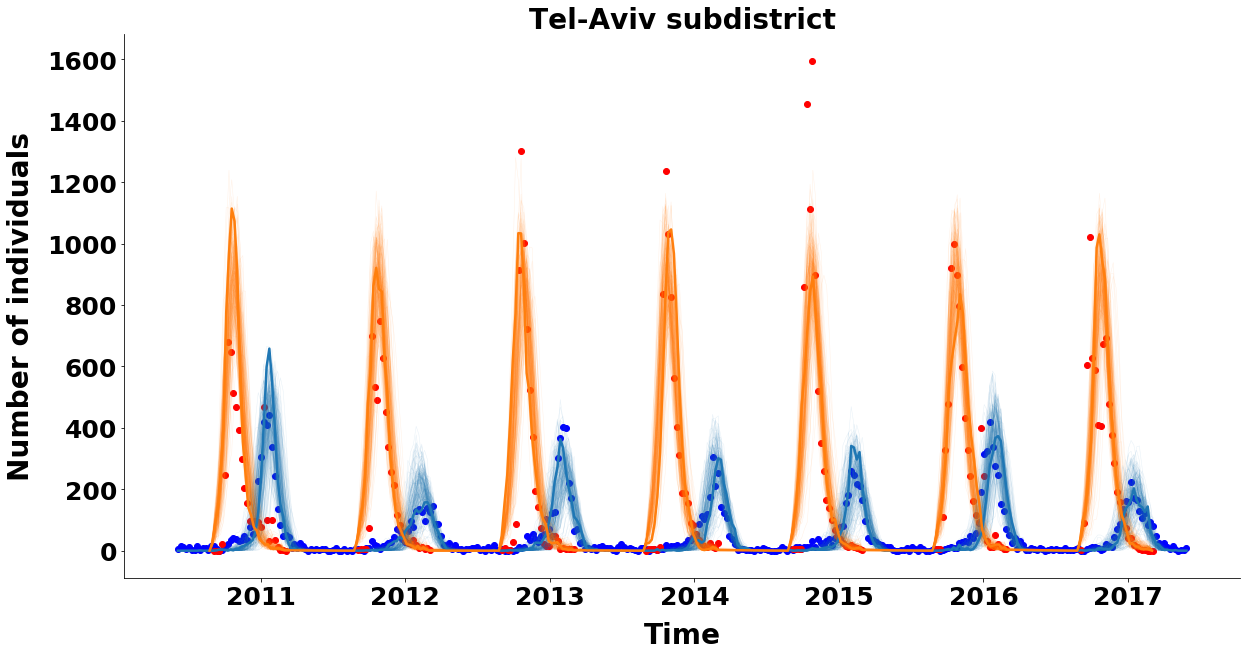

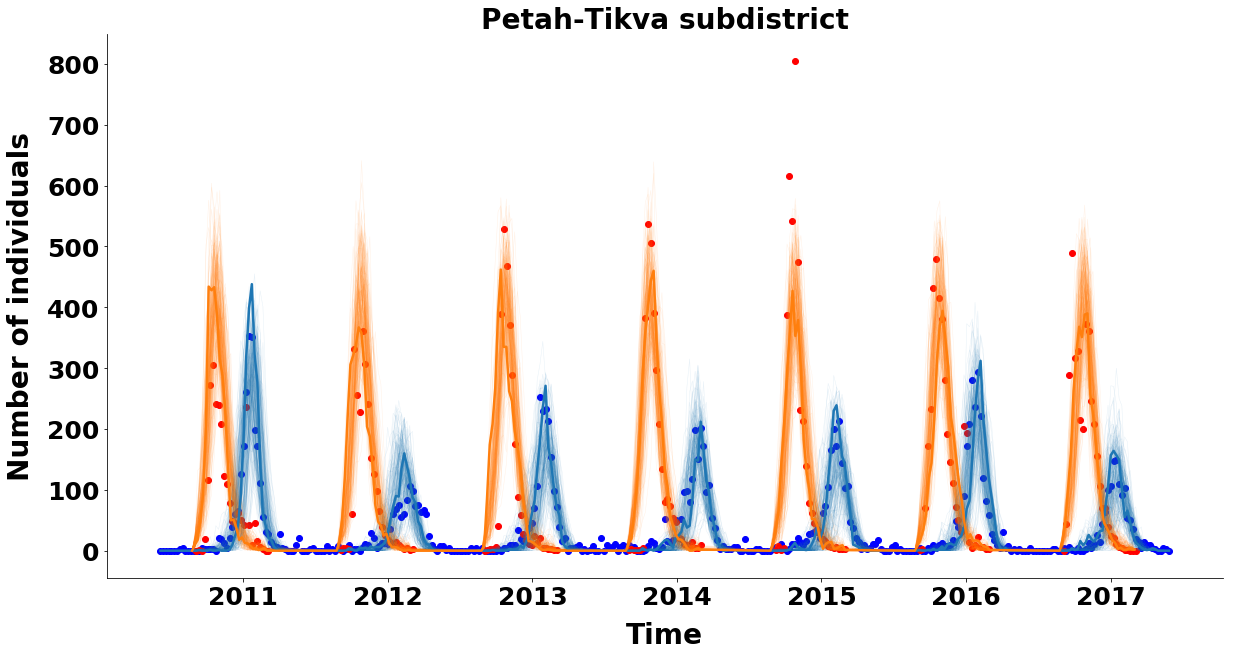

In [13]:
plot_fit_single_subdist_coupled_with_cloud(model_results_list, likelihood_lists, data_for_fit_i, data_for_fit_v, prep_data, 51)
plot_fit_single_subdist_coupled_with_cloud(model_results_list, likelihood_lists, data_for_fit_i, data_for_fit_v, prep_data, 42)

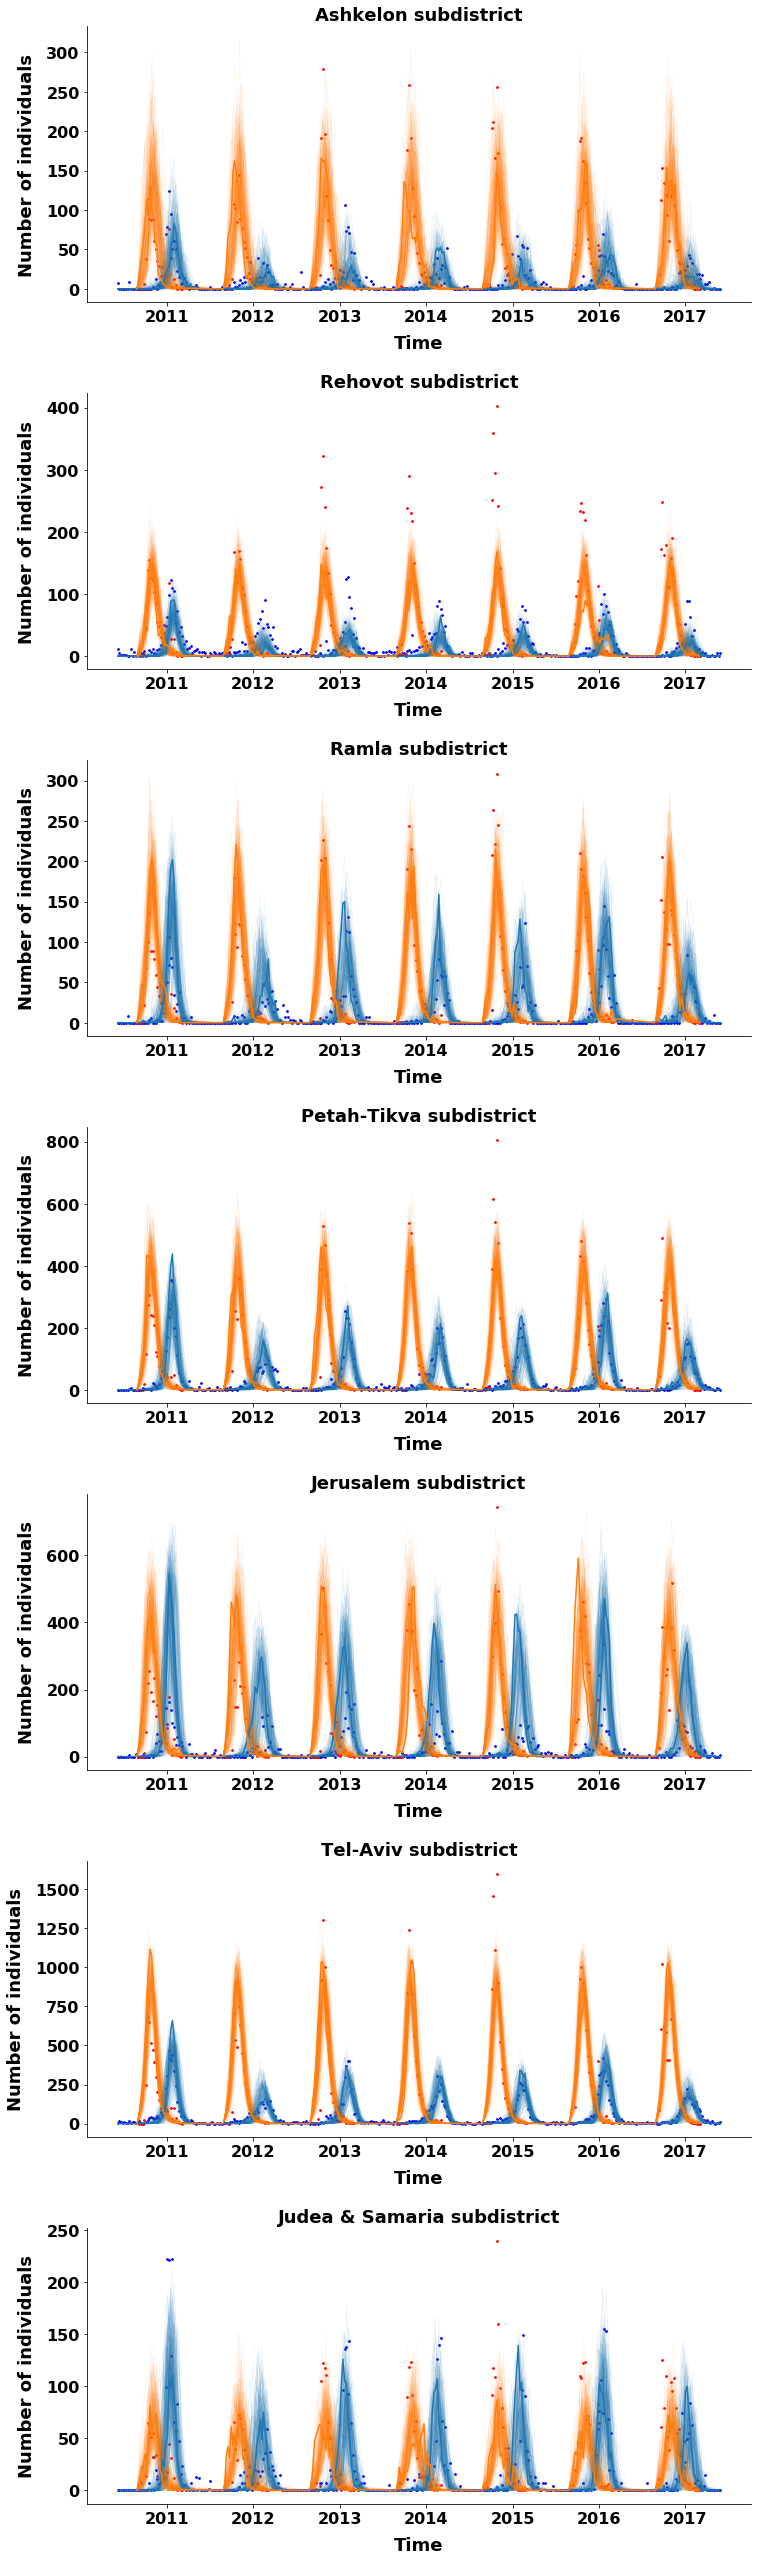

In [14]:
plot_fit_by_subdist_coupled_with_cloud(model_results_list, likelihood_lists, data_for_fit_i, data_for_fit_v, prep_data)

# Functions

In [9]:
seasons = model.seasons
get_model_weekly_cases_all_seasons = model.get_model_weekly_cases_all_seasons
get_coupled_model_weekly_vacc_all_seasons = model.get_coupled_model_weekly_vacc_all_seasons
get_model_weekly_cases = model.get_model_weekly_cases
get_coupled_model_weekly_vacc = model.get_coupled_model_weekly_vacc

In [10]:
# Load vaccination data all seasons
with open('../../Data/vaccination_data/vaccination_data_all_seasons_adjusted.pickle', 'rb') as pickle_in:
    vacc_data_all_seasons = pickle.load(pickle_in)

In [11]:
def plot_aggregated_fit_coupled_with_cloud(model_results_list, likelihood_lists, data_for_fit_i, data_for_fit_v,
                                           prep_data, age=None, vacc_start=92, plot_max=False, legend=True):
    alpha = 0.1
    # Get median realization for each season
    meds = {season: np.argsort(np.array(like_list))[len(like_list) // 2] for season, like_list in likelihood_lists.items()}

    if plot_max:
        meds = {season: np.argmax(np.array(like_list)) for season, like_list in likelihood_lists.items()}

    # Create fig
#     plt.figure(figsize=(20, 10))
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Make all bold
    plt.rc('font', weight='bold')

    # Get relevant dates - for vaccination plot
    all_dates = []
    for season in seasons:
        # Get vaccination season start date (minus 1 week)
        start_date = pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=vacc_start - 7)
        # Get the season range - form start date (minus week)
        dates = [start_date + pd.Timedelta(days=7) * i for i in range(27 + 1)]
        # Add to the list
        all_dates.extend(dates)

    # Go over results list
    for res_all_seasons in model_results_list:
        # Influenza model
        # Get data to plot and model results
        # If children
        if age == 0:
            infected_data_for_plot = data_for_fit_i['by_age'][0]
            model_weekly_cases = get_model_weekly_cases_all_seasons(res_all_seasons, prep_data, age=0)
        # If adult
        elif age == 1:
            infected_data_for_plot = data_for_fit_i['by_age'][1]
            model_weekly_cases = get_model_weekly_cases_all_seasons(res_all_seasons, prep_data, age=1)
        # If total
        else:
            infected_data_for_plot = data_for_fit_i['total']
            model_weekly_cases = get_model_weekly_cases_all_seasons(res_all_seasons, prep_data)

        # Plot flu model - all realization
        plt.plot(model_weekly_cases.index, model_weekly_cases.cases, linewidth=0.5, label='influenza model', c='C0', alpha=alpha)

        # Vaccination model
        # Get data to plot and model results
        # If children
        if age == 0:
            vacc_data_for_plot = vacc_data_all_seasons['by_age'][0]
            model_weekly_vacc = get_coupled_model_weekly_vacc_all_seasons(res_all_seasons, prep_data, age=age)
        # If adult
        elif age == 1:
            vacc_data_for_plot = vacc_data_all_seasons['by_age'][1]
            model_weekly_vacc = get_coupled_model_weekly_vacc_all_seasons(res_all_seasons, prep_data, age=age)
        # If total
        else:
            vacc_data_for_plot = vacc_data_all_seasons['total']
            model_weekly_vacc = get_coupled_model_weekly_vacc_all_seasons(res_all_seasons, prep_data, age=age)

        # Plot vaccination model - all realization
        plt.plot(all_dates, model_weekly_vacc, linewidth=0.5, label='vaccination model', c='C1', alpha=alpha)

    # Plot flu data
    flu_data_plt = plt.scatter(infected_data_for_plot.index, infected_data_for_plot.cases, c='b', label='influenza data')

    # Plot vaccination data
#     # Add 0 before the first point - for plotting
#     vacc_data_for_plot = np.concatenate([[0], vacc_data_for_plot.vacc_count])
    vacc_data_plt = plt.scatter(vacc_data_for_plot.index, vacc_data_for_plot.vacc_count, c='r', label='vaccination data')

    # Plot median realizations
    # Initialize a list for vaccination resluts
    vacc_res = [[0]]

    # Go over seasons
    for s, (season, med) in enumerate(meds.items()):
        # Get model results - median result of current season
        med_results = model_results_list[med][s]

        # Influenza model
        # If children
        if age == 0:
            model_weekly_cases = get_model_weekly_cases(med_results, season, age=0)
        # If adult
        elif age == 1:
            model_weekly_cases = get_model_weekly_cases(med_results, season, age=1)
        # If total
        else:
            model_weekly_cases = get_model_weekly_cases(med_results, season)

        # Plot median result for current season
        med_plot_flu = plt.plot(model_weekly_cases.index, model_weekly_cases.cases, linewidth=2.5, label='influenza model', c='C0')

        # Vaccination model
        # If children
        if age == 0:
            model_weekly_vacc = get_coupled_model_weekly_vacc(med_results, prep_data, age=age)
        # If adult
        elif age == 1:
            model_weekly_vacc = get_coupled_model_weekly_vacc(med_results, prep_data, age=age)
        # If total
        else:
            model_weekly_vacc = get_coupled_model_weekly_vacc(med_results, prep_data)

        # Add to the list
        vacc_res.append(model_weekly_vacc)
        vacc_res.append([0])

    # Plot median result for current season - vaccination (plot the concatenation of all seasons)
    med_plot_vacc = plt.plot(all_dates, np.concatenate(vacc_res[:-1]), linewidth=2.5, label='vaccination model', c='C1')

    plt.title(f'{"All population" if age is None else ["Children (Total Population)", "Adults (Total Population)"][age]}', size=28, fontweight='bold')
    plt.xlabel('Time', size=28, labelpad=12, fontweight='bold')
    plt.ylabel('Number of individuals', size=28, labelpad=12, fontweight='bold')

    plt.tick_params(labelsize=25)
    
    if legend:
        if age == 0:
            plt.legend(handles=[med_plot_flu[0], med_plot_vacc[0], flu_data_plt, vacc_data_plt], fontsize=22, loc='upper right',
                       frameon=False)
        else:
            plt.legend(handles=[med_plot_flu[0], med_plot_vacc[0], flu_data_plt, vacc_data_plt], fontsize=22, loc=(0.9, 0.75),
                       frameon=False)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()

In [10]:
def plot_fit_by_subdist_coupled_with_cloud(model_results_list, likelihood_lists, data_for_fit_i, data_for_fit_v, prep_data, vacc_start=92,
                                           plot_max=False):
    alpha = 0.1

    # Create figure
    fig, axs = plt.subplots(nrows=7, ncols=1, figsize=(10, 35))
    plt.tight_layout(w_pad=3, h_pad=7)
    
    # Make all bold
    plt.rc('font', weight='bold')

    # Get subdists names
    subdists_names = {11.0: 'Jerusalem', 41.0: 'Sharon', 42.0: 'Petah-Tikva', 43.0: 'Ramla', 44.0: 'Rehovot', 51.0: 'Tel-Aviv',
                      61.0: 'Ashkelon', 77.0: 'Judea & Samaria'}

    # Get median realization for each season
    meds = {season: np.argsort(np.array(like_list))[len(like_list) // 2] for season, like_list in likelihood_lists.items()}

    if plot_max:
        meds = {season: np.argmax(np.array(like_list)) for season, like_list in likelihood_lists.items()}

    # Get relevant dates - for vaccination plot
    all_dates = []
    for season in seasons:
        # Get vaccination season start date (minus 1 week)
        start_date = pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=vacc_start - 7)
        # Get the season range - form start date (minus week)
        dates = [start_date + pd.Timedelta(days=7) * i for i in range(27 + 1)]
        # Add to the list
        all_dates.extend(dates)

    # Go over results list
    for res_all_seasons in model_results_list:
        # Influenza model
        # Get weekly cases for each subdist
        model_weekly_cases_by_subdist = get_model_weekly_cases_all_seasons(res_all_seasons, prep_data, by_subdist=True)

        for i, subdist in enumerate(model_weekly_cases_by_subdist):
            # Plot newly infected - model
            axs[i].plot(model_weekly_cases_by_subdist[subdist].index, model_weekly_cases_by_subdist[subdist].cases,
                        label='influenza model', linewidth=0.5, c='C0', alpha=alpha)
            # axs attributes
            axs[i].set_title(f'{subdists_names[subdist]} subdistrict', size=18, fontweight='bold')
            axs[i].set_xlabel('Time', size=18, fontweight='bold', labelpad=10)
            axs[i].set_ylabel('Number of individuals', size=18, fontweight='bold', labelpad=10)

            axs[i].tick_params(labelsize=16)
            
            # Hide the right and top spines
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['top'].set_visible(False)

        # Vaccination model
        # Get weekly vaccination for each subdist
        model_weekly_vacc_by_subdist = get_coupled_model_weekly_vacc_all_seasons(res_all_seasons, prep_data, by_subdist=True)

        for i, subdist in enumerate(model_weekly_vacc_by_subdist):
            # Plot newly infected - model
            axs[i].plot(all_dates, model_weekly_vacc_by_subdist[subdist],
                        label='vaccination model', linewidth=0.5, c='C1', alpha=alpha)

    # Plot data
    # Plot flu data
    for i, subdist in enumerate(model_weekly_cases_by_subdist):
        data = data_for_fit_i['by_subdist'][(subdist, 0)].copy()
        data.cases += data_for_fit_i['by_subdist'][(subdist, 1)].cases
        flu_data_plt = axs[i].scatter(data.index, data.cases, label='influenza data', c='b', s=3)

    # Plot vaccination data
    for i, subdist in enumerate(model_weekly_vacc_by_subdist):
        vacc_data = vacc_data_all_seasons['by_subdist_age'][(subdist, 0)].copy()
        vacc_data.vacc_count += vacc_data_all_seasons['by_subdist_age'][(subdist, 1)].vacc_count
#         vacc_data = np.concatenate([[0], vacc_data.vacc_count])
        vacc_data_plt = axs[i].scatter(vacc_data.index, vacc_data.vacc_count, label='vaccination data', c='r', s=3)

    # Plot median realizations
    # Initialize a list for vaccination resluts
    vacc_res = {subdist: [[0]] for subdist in prep_data['relevant_subdists']}

    # Go over seasons
    for s, (season, med) in enumerate(meds.items()):
        # Get model results - median result of current season
        med_results = model_results_list[med][s]

        # Influenza model
        # Initialize dict for weekly cases by subdist - all arrays of 0s
        Is_by_subdist = {subdist: np.array([0] * 365) for subdist in prep_data['relevant_subdists']}

        # Go over clinics and aggregate by subdists
        for (clinic, age), data in med_results['Is_by_clinic_age'].items():
            subdist = prep_data['clinics_stat_areas'].loc[clinic].subdist
            Is_by_subdist[subdist] = Is_by_subdist[subdist] + data

        # Get weekly cases for each subdist
        model_weekly_cases_by_subdist = {}
        for subdist, data in Is_by_subdist.items():
            model_weekly_cases_by_subdist[subdist] = get_model_weekly_cases(data, season, short=False, by_subdist=True)

        # Go over subdists and plot
        for i, subdist in enumerate(model_weekly_cases_by_subdist):
            # Plot newly infected - model
            med_plot_flu = axs[i].plot(model_weekly_cases_by_subdist[subdist].index, model_weekly_cases_by_subdist[subdist].cases,
                                       label='influenza model', linewidth=1.5, c='C0')

        # Vaccination model
        # Get weekly vaccination for each subdist
        model_weekly_vacc_by_subdist = get_coupled_model_weekly_vacc(med_results, prep_data, by_subdist=True)

        # Add to the relevant list
        for subdist, weekly_vacc in model_weekly_vacc_by_subdist.items():
            vacc_res[subdist].append(weekly_vacc)
            vacc_res[subdist].append([0])

    # Plot median result for current season - vaccination (plot the concatenation of all seasons)
    for i, subdist in enumerate(model_weekly_vacc_by_subdist):
        # Plot newly infected - model
        med_plot_vacc = axs[i].plot(all_dates, np.concatenate(vacc_res[subdist][:-1]), label='vaccination model',
                                    linewidth=1.5, c='C1')

#     plt.legend(handles=[med_plot_flu[0], med_plot_vacc[0], flu_data_plt, vacc_data_plt], fontsize=12, loc=(1.02, 8.4))
    

    plt.show()

In [11]:
def plot_fit_single_subdist_coupled_with_cloud(model_results_list, likelihood_lists, data_for_fit_i, data_for_fit_v, prep_data, chosen_subdist, vacc_start=92,
                                           plot_max=False):
    alpha = 0.1

    # Create figure
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Make all bold
    plt.rc('font', weight='bold')

    # Get subdists names
    subdists_names = {11.0: 'Jerusalem', 41.0: 'Sharon', 42.0: 'Petah-Tikva', 43.0: 'Ramla', 44.0: 'Rehovot', 51.0: 'Tel-Aviv',
                      61.0: 'Ashkelon', 77.0: 'Judea & Samaria'}

    # Get median realization for each season
    meds = {season: np.argsort(np.array(like_list))[len(like_list) // 2] for season, like_list in likelihood_lists.items()}

    if plot_max:
        meds = {season: np.argmax(np.array(like_list)) for season, like_list in likelihood_lists.items()}

    # Get relevant dates - for vaccination plot
    all_dates = []
    for season in seasons:
        # Get vaccination season start date (minus 1 week)
        start_date = pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=vacc_start - 7)
        # Get the season range - form start date (minus week)
        dates = [start_date + pd.Timedelta(days=7) * i for i in range(27 + 1)]
        # Add to the list
        all_dates.extend(dates)

    # Go over results list
    for res_all_seasons in model_results_list:
        # Influenza model
        # Get weekly cases for each subdist
        model_weekly_cases_by_subdist = get_model_weekly_cases_all_seasons(res_all_seasons, prep_data, by_subdist=True)
        
        ax.plot(model_weekly_cases_by_subdist[chosen_subdist].index, model_weekly_cases_by_subdist[chosen_subdist].cases,
                    label='influenza model', linewidth=0.5, c='C0', alpha=alpha)
        
        # axs attributes
        ax.set_title(f'{subdists_names[chosen_subdist]} subdistrict', size=28, fontweight='bold')
        ax.set_xlabel('Time', size=28, fontweight='bold', labelpad=12)
        ax.set_ylabel('Number of individuals', size=28, fontweight='bold', labelpad=12)

        ax.tick_params(labelsize=25)

        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Vaccination model
        # Get weekly vaccination for each subdist
        model_weekly_vacc_by_subdist = get_coupled_model_weekly_vacc_all_seasons(res_all_seasons, prep_data, by_subdist=True)

        # Plot newly infected - model
        ax.plot(all_dates, model_weekly_vacc_by_subdist[chosen_subdist],
                label='vaccination model', linewidth=0.5, c='C1', alpha=alpha)

    # Plot data
    # Plot flu data
    data = data_for_fit_i['by_subdist'][(chosen_subdist, 0)].copy()
    data.cases += data_for_fit_i['by_subdist'][(chosen_subdist, 1)].cases
    flu_data_plt = ax.scatter(data.index, data.cases, label='influenza data', c='b')

    # Plot vaccination data
    vacc_data = vacc_data_all_seasons['by_subdist_age'][(chosen_subdist, 0)].copy()
    vacc_data.vacc_count += vacc_data_all_seasons['by_subdist_age'][(chosen_subdist, 1)].vacc_count
    vacc_data_plt = ax.scatter(vacc_data.index, vacc_data.vacc_count, label='vaccination data', c='r')

    # Plot median realizations
    # Initialize a list for vaccination resluts
    vacc_res = {chosen_subdist: [[0]]}

    # Go over seasons
    for s, (season, med) in enumerate(meds.items()):
        # Get model results - median result of current season
        med_results = model_results_list[med][s]

        # Influenza model
        # Initialize dict for weekly cases by subdist - all arrays of 0s
        Is_by_subdist = {chosen_subdist: np.array([0] * 365)}

        # Go over clinics and aggregate by subdists
        for (clinic, age), data in med_results['Is_by_clinic_age'].items():
            subdist = prep_data['clinics_stat_areas'].loc[clinic].subdist
            if subdist == chosen_subdist:
                Is_by_subdist[chosen_subdist] = Is_by_subdist[chosen_subdist] + data

        # Get weekly cases for each subdist
        model_weekly_cases_by_subdist = {}
        for subdist, data in Is_by_subdist.items():
            model_weekly_cases_by_subdist[subdist] = get_model_weekly_cases(data, season, short=False, by_subdist=True)

        # Go over subdists and plot
        med_plot_flu = ax.plot(model_weekly_cases_by_subdist[chosen_subdist].index, model_weekly_cases_by_subdist[subdist].cases,
                                   label='influenza model', linewidth=2.5, c='C0')

        # Vaccination model
        # Get weekly vaccination for each subdist
        model_weekly_vacc_by_subdist = get_coupled_model_weekly_vacc(med_results, prep_data, by_subdist=True)

        # Add to the relevant list
        for subdist, weekly_vacc in model_weekly_vacc_by_subdist.items():
            if subdist == chosen_subdist:
                vacc_res[subdist].append(weekly_vacc)
                vacc_res[subdist].append([0])

    # Plot median result for current season - vaccination (plot the concatenation of all seasons)
    # Plot newly infected - model
    med_plot_vacc = ax.plot(all_dates, np.concatenate(vacc_res[chosen_subdist][:-1]), label='vaccination model',
                                linewidth=2.5, c='C1')

#     plt.legend(handles=[med_plot_flu[0], med_plot_vacc[0], flu_data_plt, vacc_data_plt], fontsize=12, loc=(1.02, 8.4))
    

    plt.show()